In [13]:
import re
import numpy as np
import pandas as pd
from scipy import sparse
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC



from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.externals import joblib

In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [16]:
# the docker container is too small to run the gridsearch
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [17]:
import sys
sys.path.append('../../')

In [40]:
import importlib
importlib.reload(utils)
import utils

## read data

In [19]:
train = pd.read_csv('../input/train.csv', encoding='utf-8')
test = pd.read_csv('../input/test.csv', encoding='utf-8')

In [20]:
classes = [x for x in train.columns if x not in ['id', 'comment_text']]

In [21]:
test.fillna('emptycomment', inplace=True)
train.fillna('emptycomment', inplace=True)

corr between different labels

In [22]:
test.shape

(153164, 2)

In [23]:
train.shape

(159571, 8)

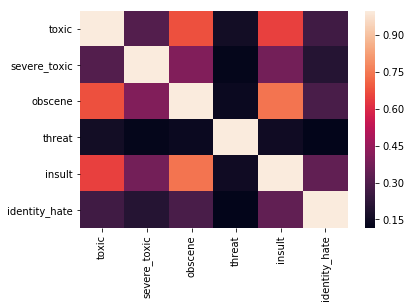

In [24]:
sns.heatmap(train[classes].corr())

## prepping features

In [25]:
st = utils.standardize_text()

In [26]:
train['comment_text_clean'] = st.clean(st.replace_entities(train['comment_text']))
test['comment_text_clean'] = st.clean(st.replace_entities(test['comment_text']))

In [27]:
rs = ShuffleSplit(n_splits=1, test_size=0.2)

In [28]:
for j, k in rs.split(train):
    train_index = j
    val_index = k

In [29]:
X_train_df = train.loc[train_index, 'comment_text_clean'] 
X_val_df = train.loc[val_index, 'comment_text_clean']
y_train = train.loc[train_index, classes]
y_val = train.loc[val_index, classes]

In [30]:
X_train_cnt = st.replace_entities(train.loc[train_index, 'comment_text']) 
X_val_cnt = st.replace_entities(train.loc[val_index, 'comment_text'])
X_test_cnt = st.replace_entities(test.loc[:, 'comment_text'])

In [34]:
cnt_feat = utils.create_count_features()
temp = pd.DataFrame(cnt_feat.transform(X_test_cnt), columns=cnt_feat.get_feature_names())

../../utils.py:66: RuntimeWarning: invalid value encountered in true_divide
  allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
../../utils.py:67: RuntimeWarning: invalid value encountered in true_divide
  bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)


In [35]:
temp.mean()

n_words           61.598385
n_chars          362.517328
allcaps            3.289193
max_word_len      13.346073
mean_word_len      4.687811
exclamation        1.172495
question           0.423611
tabs               0.020116
newlines           2.609778
wikilink           0.009735
extralink          0.033644
spaces            64.416762
bad_ratio          0.035790
n_bad              1.762562
allcaps_ratio      0.056767
dtype: float64

### count based model

In [42]:
%%time
cnt_feat = utils.create_count_features()
scaler = MinMaxScaler()
clf = RandomForestClassifier(n_estimators=200, class_weight=None, n_jobs=-1, bootstrap=True)  

pipe = Pipeline(steps=[('cnt', cnt_feat),
                       ('scaler', scaler), 
                       ('clf', clf)])

parameters = {'clf__max_depth':[10],
              'clf__max_features': [3]}

cnt_models = utils.train_best_model(pipe, parameters, X_train_cnt, y_train, X_val_cnt, y_val)

NameError: name 'train_best_model' is not defined

In [ ]:
joblib.dump(cnt_models, datetime.now().strftime('%Y%m%d%H%M')+'_cnt_models.pkl')

### word level model

In [ ]:
%%time
selec = SelectPercentile(chi2, percentile=20)
clf = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
vect_words = TfidfVectorizer(max_features=None,
                             lowercase=False,
                             analyzer='word', 
                             ngram_range=(1, 3), 
                             max_df=0.1, 
                             min_df=3,
                             stop_words='english',
                             use_idf=True)

pipe = Pipeline(steps=[('vect', vect_words),
                       ('selec', selec), 
                       ('clf', clf)])

parameters = {'vect__ngram_range': [(1,1), (1,2)],
              'selec__percentile':[5, 10, 20], 
              'clf__C':[5, 10, 20]}

wd_predictions, wd_models = train_best_model(pipe, parameters, X_train_df, y_train, X_val_df, y_val)

In [ ]:
joblib.dump(cnt_models, datetime.now().strftime('%Y%m%d%H%M')+'_wd_models.pkl')

### char level model

In [ ]:
%%time
selec = SelectPercentile(chi2, percentile=20)
clf = LogisticRegression(C=5.0, class_weight=None, n_jobs=1)  
vect_words = TfidfVectorizer(max_features=None,
                             lowercase=False,
                             analyzer='char', 
                             ngram_range=(1, 5), 
                             max_df=0.1, 
                             min_df=3,
                             stop_words='english',
                             use_idf=True)

pipe = Pipeline(steps=[('vect', vect_words),
                       ('selec', selec), 
                       ('clf', clf)])

parameters = {'vect__ngram_range': [(1, 5), (2,4)],
              'selec__percentile':[1, 5, 10], 
              'clf__C':[1, 10, 20]}

char_predictions, char_models = train_best_model(pipe, parameters, X_train_df, y_train, X_val_df, y_val)

In [ ]:
joblib.dump(cnt_models, datetime.now().strftime('%Y%m%d%H%M')+'_char_models.pkl')

## stacking all models

In [ ]:
models_list = [(wd_models, X_train_df), 
               (char_models, X_train_df)]#, 
               #(cnt_models, X_test_cnt)]

In [ ]:
%%time
X_train_stack = generate_X_stack(models_list)

In [ ]:
X_train_stack.shape

In [ ]:
%%time

clf = RandomForestClassifier(n_estimators=1000, 
                             class_weight=None, 
                             n_jobs=-1, 
                             bootstrap=True,
                             max_depth=30,
                             max_features=4)  

clf.fit(X_train_stack, y_train)

predictions = clf.predict_proba(X_train_stack)

print(log_loss(y_train, np.column_stack([x[:,1] for x in predictions]))/6.)

In [ ]:
val_list = [wd_predictions, char_predictions]#, cnt_predictions]

In [ ]:
val_stack = np.column_stack([x.values for x in pred_list])

In [ ]:
predictions = clf.predict_proba(val_stack)

print(log_loss(y_val, np.column_stack([x[:,1] for x in predictions]))/6.)

## exploration of the results

In [ ]:
df = pd.DataFrame(X_val_df.reset_index(drop=True))
df['label'] = y_val['toxic'].reset_index(drop=True)
df['pred'] = np.column_stack([x[:,1] for x in predictions])[:,0]

In [ ]:
def generate_cloud(col):
    text = '.. '.join(list(col))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
generate_cloud(df[(df.label==1) & (df.pred>0.5)].comment_text_clean)

In [ ]:
df[df.comment_text_clean.str.contains('hate u')]

In [ ]:
confusion_matrix(df.label, (df.pred>0.5))

In [ ]:
df[(df.label==0) & (df.pred>0.5)].comment_text_clean

In [ ]:
train[train.comment_text.str.contains('I promise you')]['comment_text']

# predictions on the test set

In [ ]:
models_list = [(wd_models, test['comment_text_clean']), 
               (char_models, test['comment_text_clean'])]#, 
               #(cnt_models, X_test_cnt)]

In [ ]:
%%time
X_train_stack = generate_X_stack(models_list)

In [ ]:
predictions = clf.predict_proba(X_train_stack)
predictions = pd.DataFrame(np.column_stack([x[:,1] for x in predictions]), columns=classes)
predictions['id'] = test.id

In [ ]:
predictions.to_csv(datetime.now().strftime('%Y%m%d%H%M')+'_submission.csv', index=False)